In [228]:
#Import the libraries
import math
#import pandas_datareader as web
import numpy as np
import pandas as pd
from datetime import datetime
import pytz
import MetaTrader5 as mt5
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [229]:
mt5.initialize()

True

In [230]:
'''print(mt5.symbol_info('WDO$'))
for i in mt5.symbol_info('WDO$'):
    print (i)'''

"print(mt5.symbol_info('WDO$'))\nfor i in mt5.symbol_info('WDO$'):\n    print (i)"

In [231]:
from_date=datetime(2022,1,1)
to_date=datetime.now()
rates = mt5.copy_rates_range("WDO$", mt5.TIMEFRAME_D1, from_date, to_date)
#rates = mt5.copy_rates_range("WDO$", mt5.TIMEFRAME_H1, from_date, to_date)
df = pd.DataFrame(rates)
df['Data']=pd.to_datetime(df['time'], unit='s')
#df.set_index('Data', inplace=True)
df.drop(columns=['time', 'tick_volume', 'spread', 'real_volume'], inplace=True)
'''df = pd.read_excel('BRKM5.xlsx', sheet_name='model')
#df['Data'] = pd.to_datetime(df['Data'])
#df.set_index('Data', inplace=True)'''
df.set_index('Data')#df.set_index('Data', inplace=True)

,open,high,low,close
Data,,,,
2022-01-03,6060.389,6189.495,6044.724,6187.334
2022-01-04,6163.026,6208.401,6128.453,6171.669
2022-01-05,6174.370,6219.745,6131.695,6187.334
2022-01-06,6187.334,6219.745,6159.784,6174.910
2022-01-07,6170.588,6201.379,6102.524,6121.431
...,...,...,...,...
2022-11-09,5193.500,5220.000,5156.000,5204.000
2022-11-10,5264.500,5435.500,5262.500,5369.500
2022-11-11,5360.000,5426.500,5269.000,5366.000


In [232]:
df.shape

(219, 5)

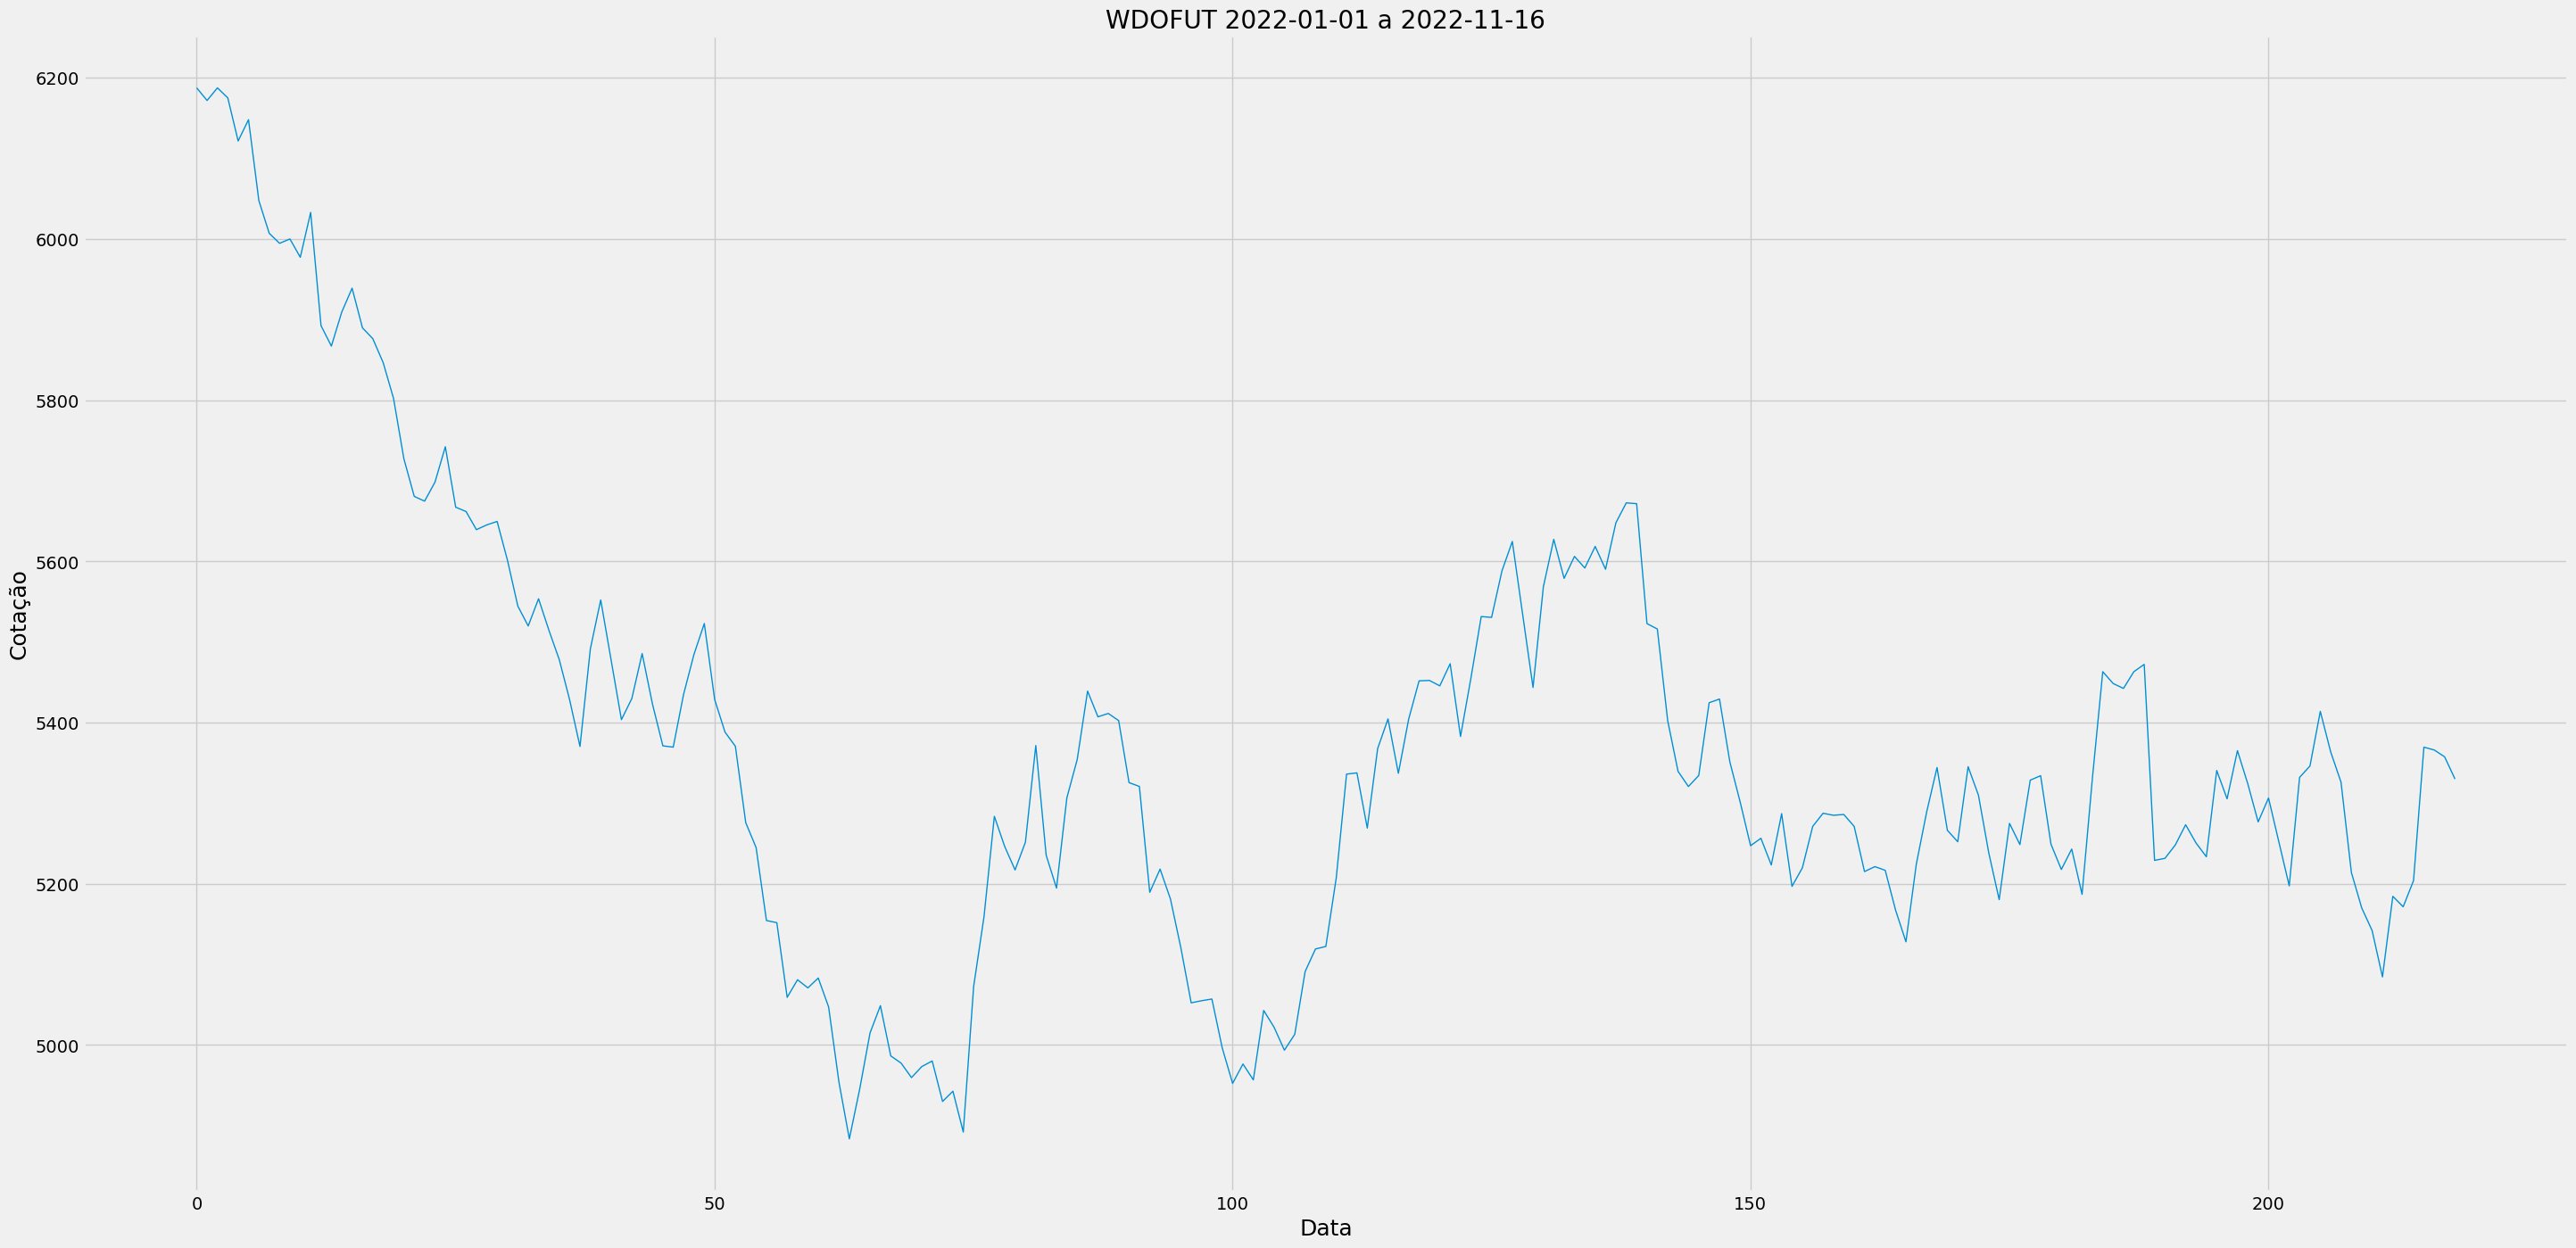

In [233]:
#Visualize the closing price history
plt.figure(figsize=(32,16))
plt.title('WDOFUT {:%Y-%m-%d} a {:%Y-%m-%d}'.format(from_date, to_date))
plt.plot(df['close'], linewidth=1)
plt.xlabel('Data',fontsize=18)
plt.ylabel('Cotação',fontsize=18)
plt.show()

In [234]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil(len(dataset) *0.8)
#len(dataset)
print(len(dataset), training_data_len)

219 176


In [235]:
#Scaling all data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [236]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
len(train_data)

176

In [237]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [238]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [239]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [240]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [241]:
checkpoint_path = "training_1/cp.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=10, callbacks=[cp_callback])

Epoch 1/10
151/153 [============================>.] - ETA: 0s - loss: 0.0142
Epoch 1: saving model to training_1\cp.ckpt
153/153 [==============================] - 8s 23ms/step - loss: 0.0142
Epoch 2/10
151/153 [============================>.] - ETA: 0s - loss: 0.0076
Epoch 2: saving model to training_1\cp.ckpt
153/153 [==============================] - 4s 24ms/step - loss: 0.0077
Epoch 3/10
152/153 [============================>.] - ETA: 0s - loss: 0.0064
Epoch 3: saving model to training_1\cp.ckpt
153/153 [==============================] - 4s 24ms/step - loss: 0.0063
Epoch 4/10
152/153 [============================>.] - ETA: 0s - loss: 0.0062
Epoch 4: saving model to training_1\cp.ckpt
153/153 [==============================] - 4s 25ms/step - loss: 0.0063
Epoch 5/10
153/153 [==============================] - ETA: 0s - loss: 0.0056
Epoch 5: saving model to training_1\cp.ckpt
153/153 [==============================] - 4s 27ms/step - loss: 0.0056
Epoch 6/10
152/153 [====================

In [242]:
#Test data set
test_data = scaled_data[training_data_len - simple: , : ]
print(test_data)
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(simple,len(test_data)):
    x_test.append(test_data[i-simple:i,0])
print(y_test)

[[0.34704536]
 [0.34823961]
 [0.29570561]
 [0.37132233]
 [0.39957937]
 [0.34784153]
 [0.39957937]
 [0.43579578]
 [0.43619386]
 [0.43102031]
 [0.45211337]
 [0.38286445]
 [0.43813979]
 [0.49696797]
 [0.4961787 ]
 [0.54039897]
 [0.56843127]
 [0.49894228]
 [0.42945328]
 [0.52539528]
 [0.57040559]
 [0.53329176]
 [0.55421762]
 [0.54316255]
 [0.56369339]
 [0.54197827]
 [0.58619854]
 [0.60515008]
 [0.60436082]
 [0.49025654]
 [0.48512364]
 [0.39786738]
 [0.34969925]
 [0.33523785]
 [0.34579051]
 [0.41496733]
 [0.41848489]
 [0.35868797]
 [0.32038679]
 [0.27895848]
 [0.28599359]
 [0.26058987]
 [0.30944371]
 [0.24026613]
 [0.25785391]
 [0.29732785]
 [0.30983412]
 [0.30787976]
 [0.30866135]
 [0.29732785]
 [0.25433635]
 [0.25902591]
 [0.25550913]
 [0.21759837]
 [0.18750431]
 [0.26137146]
 [0.31103911]
 [0.35333416]
 [0.29357789]
 [0.28271304]
 [0.35411039]
 [0.32694789]
 [0.2718482 ]
 [0.22761259]
 [0.30017427]
 [0.27999702]
 [0.34130498]
 [0.34557345]
 [0.28038437]
 [0.25632677]
 [0.27572855]
 [0.23

In [243]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)
print(x_test)

[[0.34704536 0.34823961 0.29570561 ... 0.2718482  0.22761259 0.30017427]
 [0.34823961 0.29570561 0.37132233 ... 0.22761259 0.30017427 0.27999702]
 [0.29570561 0.37132233 0.39957937 ... 0.30017427 0.27999702 0.34130498]
 ...
 [0.28599359 0.26058987 0.30944371 ... 0.22083443 0.24576259 0.3727045 ]
 [0.26058987 0.30944371 0.24026613 ... 0.24576259 0.3727045  0.37001993]
 [0.30944371 0.24026613 0.25785391 ... 0.3727045  0.37001993 0.36350025]]


In [244]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [245]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

2/2 [==============================] - 1s 16ms/step


In [246]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

81.64364122110463

C:\Users\pc performance\AppData\Local\Temp\ipykernel_8328\2955326003.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions
C:\Users\pc performance\AppData\Local\Temp\ipykernel_8328\2955326003.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Data'] = data_valid
C:\Users\pc performance\AppData\Local\Temp\ipykernel_8328\2955326003.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

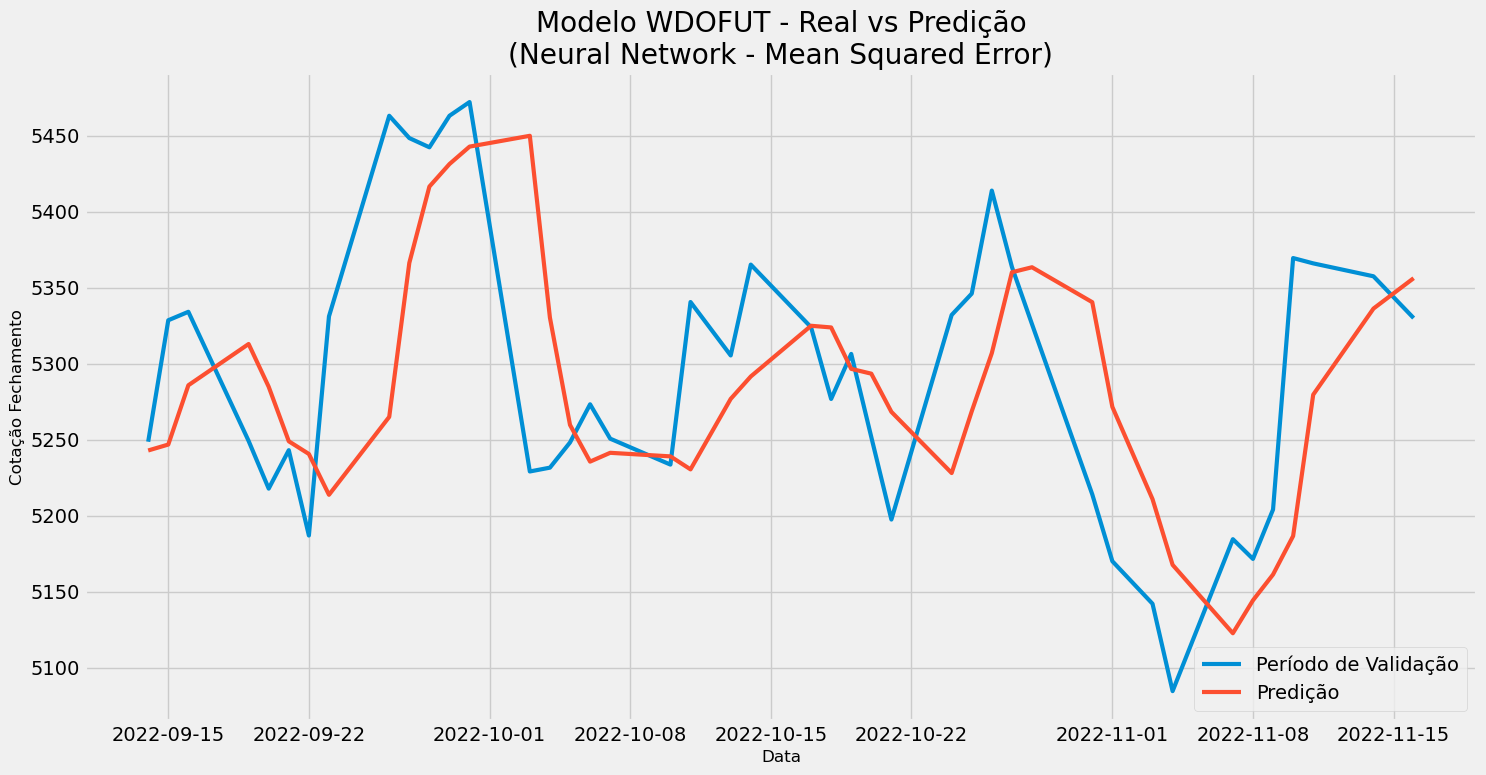

In [247]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
data_valid = df['Data'][len(df['Data'])-len(valid['Predictions']):]
valid['Data'] = data_valid
valid['Data'] = pd.to_datetime(valid['Data'])
valid.set_index('Data', inplace=True)


#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Modelo WDOFUT - Real vs Predição\n(Neural Network - Mean Squared Error)')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Cotação Fechamento', fontsize=12)
#plt.plot(train['close'], linewidth=1)
plt.plot(valid[['close', 'Predictions']], linewidth=3)
plt.legend(['Período de Validação', 'Predição'], loc='lower right')
plt.show()

In [248]:
df[-1:]

,open,high,low,close,Data
218,5360.0,5394.5,5326.0,5330.0,2022-11-16


In [249]:
valid

,close,Predictions
Data,,
2022-09-14,5248.633,5242.868164
2022-09-15,5328.563,5246.770020
2022-09-16,5334.128,5285.779297
2022-09-19,5249.138,5312.936523
2022-09-20,5217.773,5284.771484
2022-09-21,5243.068,5248.918945
2022-09-22,5186.914,5240.572754
2022-09-23,5331.093,5213.690430
2022-09-26,5463.131,5264.983887
